In [29]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Seminar 1 - Linear Regression

Javier González Otero - 243078

Jordi Guillén González - 253027

David Sánchez Maldonado - 253798

## Info

contention window -> es como el tiempo máximo de cola que un paquete debe hacer para poder ser enviado. Al enviar un paquete se escoge un backoff random entre 0 y contention window, entonces, se envia primero el paquete con backof mas pequeño y se van enviando por orden. Si es muy peque para el numero de paquetes a enviar entonces podemos tener colisiones, lo que implica reenvio del paquete, si es muy grande, esperaremos de más, pero evitamos colisiones.

chanel width -> contra más grande, más variabilidad de datos pueden enviarse al mismo tiempo, cada cosa que se envia, se envia a una frecuencia distinta

packet size -> tenemos que si es muy grande, podemos transmitir más datos si además el channel width es grande y tenemos pocos overheads (la proporcion de datos en cada  paquete es grande). El tema es que si lo perdemos, tenemos que volver a enviar todo el paquete, por tanto, si nuestra red no es muy segura en ese aspecto, conviene tener paquetes más pequeños

RSSI -> es lo del netspot, osea la intensidad de la señal. Tenemos el máximo, el minimo y el avg

Throughput -> Cantidad total de datos que se envian exitosamente (datos salientes) a través de la red por segundo bits por segundo

## Part 1 - Data Preparation & EDA

### Data preparation

In [35]:
# Path to file containing data
file_path = "data/dataset_Seminar1.txt"

# Column names
column_names = [
    "num_STAs", "load_Mbps", "size_x_m", "size_y_m", "area_m2",
    "cw_slots", "channel_width_MHz", "packet_size_bits",
    "max_RSSI_dBm", "avg_RSSI_dBm", "min_RSSI_dBm",
    "avg_prob_failure", "throughput_bps", "avg_delay_s",
    "total_airtime_s", "prop_airtime"
]

# Load data into a pandas dataframe
dataframe = pd.read_csv(file_path, sep=r'\s+', header=None, names=column_names)

# Drop unwanted columns
columns_to_drop = ["avg_prob_failure", "avg_delay_s", "total_airtime_s", "prop_airtime"]
dataframe = dataframe.drop(columns=columns_to_drop)

# Original values for each "categorical numeric" variable
cw_values = sorted(dataframe["cw_slots"].unique())
channel_width_values = sorted(dataframe["channel_width_MHz"].unique())
packet_size_values = sorted(dataframe["packet_size_bits"].unique())

### Data statistics

In [21]:
dataframe.describe()

,num_STAs,load_Mbps,size_x_m,size_y_m,area_m2,cw_slots,channel_width_MHz,packet_size_bits,max_RSSI_dBm,avg_RSSI_dBm,min_RSSI_dBm,throughput_bps
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,21.446170,2.140292e+07,20.562940,20.479640,421.270350,227.043920,75.106000,7997.580000,-45.911165,-57.577426,-66.467827,9.716009e+06
std,11.554365,1.852042e+07,11.545206,11.540626,360.344349,323.350855,53.704279,2825.532513,5.400265,6.108548,8.057528,4.958025e+06
min,2.000000,5.000000e+05,1.000000,1.000000,1.000000,3.000000,20.000000,4000.000000,-81.405165,-81.405165,-84.333834,5.000000e+05
25%,11.000000,7.250000e+06,11.000000,11.000000,120.000000,15.000000,20.000000,6000.000000,-48.131476,-61.985000,-72.637078,6.187692e+06
50%,21.000000,1.600000e+07,21.000000,20.000000,320.000000,63.000000,80.000000,8000.000000,-44.111064,-58.163205,-67.997587,9.113764e+06
75%,31.000000,3.000000e+07,31.000000,30.000000,640.000000,255.000000,160.000000,10000.000000,-41.888821,-53.589525,-61.525848,1.343290e+07
max,41.000000,8.200000e+07,40.000000,40.000000,1600.000000,1023.000000,160.000000,12000.000000,-40.863587,-40.865960,-40.865960,2.262273e+07


### Normalize data

In [23]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to the entire DataFrame
normalized_data = scaler.fit_transform(dataframe)

# Convert the result back to a pandas DataFrame with the original column names
normalized_df = pd.DataFrame(normalized_data, columns=dataframe.columns)

# Original values for each "categorical numeric" variable
normalized_cw_values = sorted(normalized_df["cw_slots"].unique())
normalized_channel_width_values = sorted(normalized_df["channel_width_MHz"].unique())
normalized_packet_size_values = sorted(normalized_df["packet_size_bits"].unique())

In [25]:
# Mapping of categorical variables to original values (normalized value : original value)
cw_mapping = {norm_val: orig_val for norm_val, orig_val in zip(normalized_cw_values, cw_values)}
channel_width_mapping = {norm_val: orig_val for norm_val, orig_val in zip(normalized_channel_width_values, channel_width_values)}
packet_size_mapping = {norm_val: orig_val for norm_val, orig_val in zip(normalized_packet_size_values, packet_size_values)}

### Plot Relevant data

#### Histograms

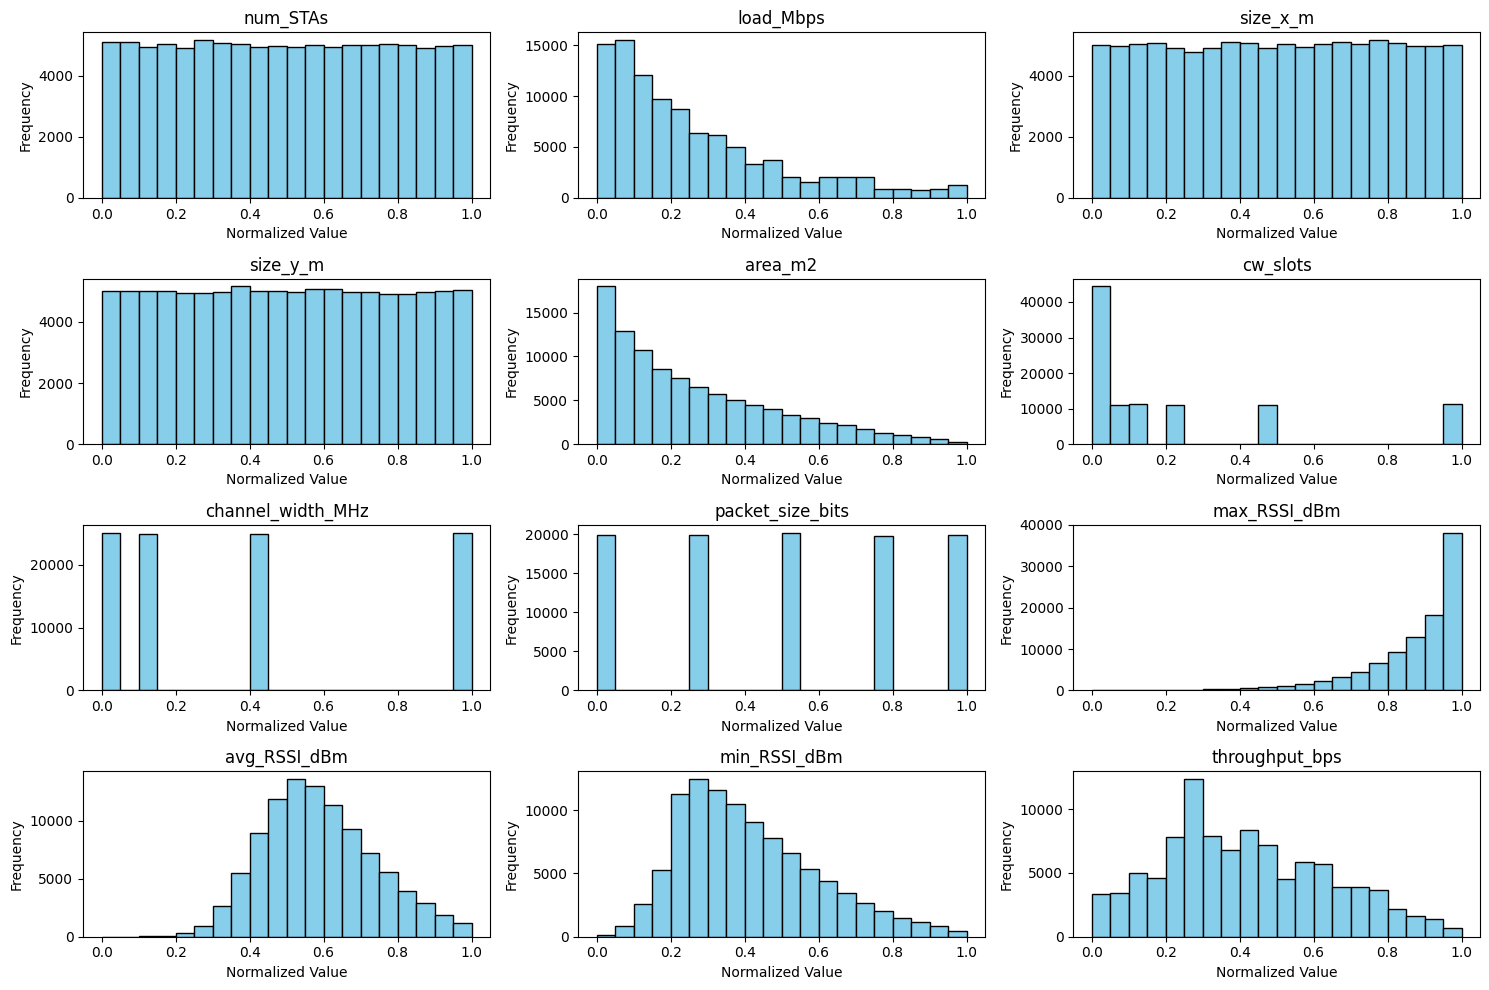

In [39]:
# List of columns to plot
columns_to_plot = normalized_df.columns.tolist()

# Create figure and axes with 3 rows and 3 columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the grid to easily iterate over it

# Plot a histogram for each variable
for i, col in enumerate(columns_to_plot):
    axes[i].hist(normalized_df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel("Normalized Value")
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots (if less than 9 variables)
for j in range(len(columns_to_plot), 9):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()